importing Jupyter notebook from model_test_for_openmax_revise2.ipynb
hate_data : 90000
genderbias_data : 1232
ilbe_data : 2044
<class 'pandas.core.frame.DataFrame'>
등장 빈도가 1번 이하인 희귀 단어의 수: 26388
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.86194622767431
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 50.13679890560876
문장 최대 길이 : 194
문장 평균 길이 : 9.977630


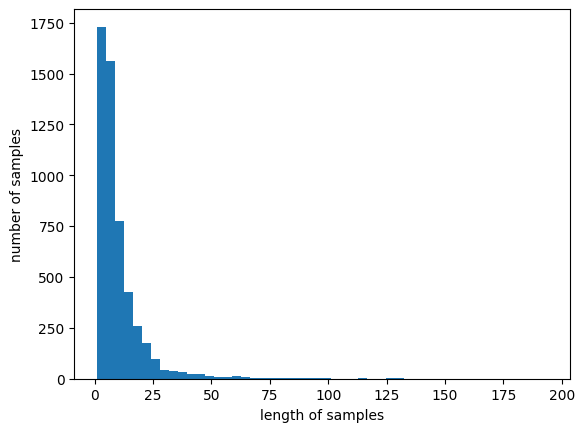

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 194, 64)           64000000  
                                                                 
 dropout (Dropout)           (None, 194, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 192, 64)           12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

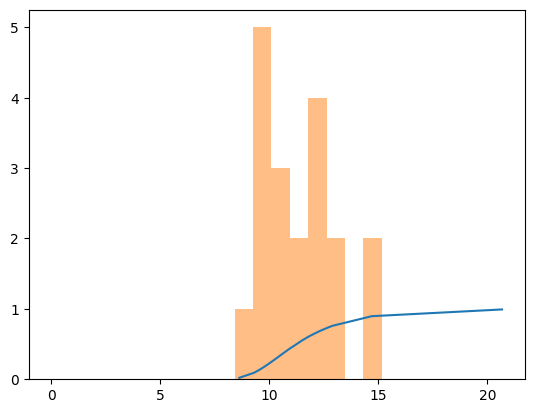

12.231698490405988 10.809680565084179


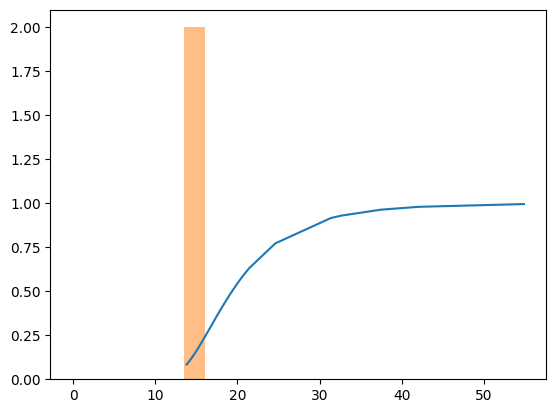

11.58359786528105 2.25338583097953


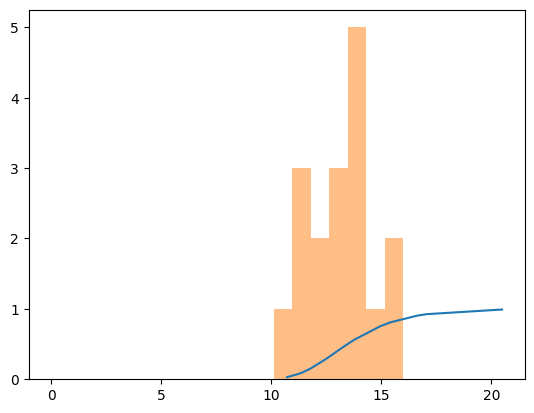

66/66 [==============================] - 0s 938us/step


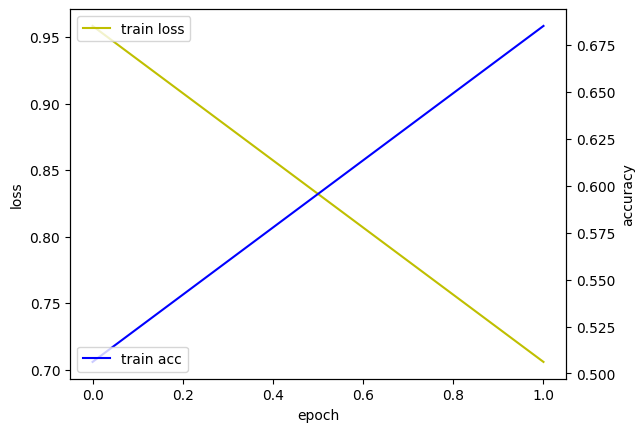

33/33 [==============================] - 0s 4ms/step - loss: 0.9215 - accuracy: 0.5336 - f1: 0.9501 - precision: 0.7135 - recall: 1.4473
테스트 정확도: 0.5336


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import import_ipynb
import model_test_for_openmax_revise2
from model_test_for_openmax_revise2 import *

In [2]:
input_data = str(input())

In [3]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [4]:
x_data = []
x_data.append(input_data)
y_data = -1    # 임시 값

x_data

['저 개돼지는 정신 언제 차리냐? ㅋㅋㅋ']

In [5]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)
sequences

[[1, 2, 3, 4, 5, 6]]

## 모델 적용

In [6]:
from keras.models import model_from_json
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [7]:
loaded_model.load_weights("model_weight.h5")

In [8]:
loaded_model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),metrics= ["accuracy",f1,precision, recall])
es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
check_point = ModelCheckpoint('apply_model.h5', monitor='loss', mode='min', save_best_only=True)

In [9]:
data = sequences
X_data = pad_sequences(data, maxlen = model_test_for_openmax_revise2.maxlen)
X_result = model_test_for_openmax_revise2.model.predict(X_data, batch_size=32)
X_Softmax = model_test_for_openmax_revise2.model2.predict(X_result)

X_result = X_result[0]
X_result

1/1 [==============================] - 0s 22ms/step


array([ 1.4901943, -3.4639125,  1.9844636], dtype=float32)

## logit Vector, Distance 계산

## 모델 저장

In [10]:
def distance(logit_vector, average):
    m = []
    for i in range(0,3):
        m.append(logit_vector[i] - average[i])
    distance = (m[0]**2) + (m[1]**2) + (m[2]**2)
    return distance

dist0 = distance(X_result, average_0)
dist1 = distance(X_result, average_1)
dist2 = distance(X_result, average_2)

## CDF 계산

In [11]:
import scipy.stats as s
import matplotlib.pyplot as plt

In [12]:
def calculCDF(dist, input_loc, input_scale):
    CDF = s.exponweib.cdf(dist, *s.exponweib.fit(dist, 2, 5, scale=input_scale, loc=input_loc))     
    return CDF

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

In [13]:
maxdist0.insert(20,dist0)
maxdist0 = maxdist0[0:21]
maxdist0.sort(reverse=True)
index0 = maxdist0.index(dist0)
maxdist1.insert(20,dist1)
maxdist1 = maxdist1[0:21]
maxdist1.sort(reverse=True)
index1 = maxdist1.index(dist1)
maxdist2.insert(20,dist2)
maxdist2 = maxdist2[0:21]
maxdist2.sort(reverse=True)
index2 = maxdist2.index(dist2)

CDF0 = s.exponweib.cdf(maxdist0, *s.exponweib.fit(maxdist0, 1, 1, scale=2, loc=0))
CDF1 = s.exponweib.cdf(maxdist1, *s.exponweib.fit(maxdist1, 1, 1, scale=2, loc=0))
CDF2 = s.exponweib.cdf(maxdist2, *s.exponweib.fit(maxdist2, 1, 1, scale=2, loc=0))

input_CDF0 = CDF0[index0]
input_CDF1 = CDF1[index1]
input_CDF2 = CDF2[index2]

## Logit Vector 업데이트

In [14]:
updated_logit = []

logit0 = X_result[0]-(X_result[0]*input_CDF0)
logit1 = X_result[1]-(X_result[1]*input_CDF1)
logit2 = X_result[2]-(X_result[2]*input_CDF2)
unknown_logit = (input_CDF0*X_result[0]) + (input_CDF1*X_result[1]) + (input_CDF2*X_result[2]) # unknown class의 logit vector     

updated_logit = [unknown_logit, logit0, logit1, logit2]

updated_logit

[1.1683566842946722,
 0.22710393289187758,
 -1.6766839474737267,
 0.2919687364379948]

## Softmax Layer 통과

In [15]:
# softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [16]:
result_arr = softmax(updated_logit)
arr = result_arr.tolist()
soft_arr = max(arr)
res = arr.index(soft_arr)
prob = arr[res]

## 결과 확인

In [17]:
if(res==0):
    resultstr = "Unknown"
elif(res==1):
    resultstr = "혐오성 댓글"
elif(res==2):
    resultstr = "성차별 댓글"
elif(res == 3):
    resultstr = "일베 댓글"
    
resultstr

'Unknown'

In [18]:
print(str(prob) + " 확률로 " + resultstr +"입니다.")

0.5363211354325358 확률로 Unknown입니다.


In [19]:
print("정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 1s 5ms/step - loss: 0.9215 - accuracy: 0.5336 - f1: 0.9501 - precision: 0.7135 - recall: 1.4473
정확도: 0.5336
